[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Arch_3D.ipynb)

In [ ]:
!pip install JaxSSO
!pip install nlopt

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import JaxSSO as sso #Sensitivity analysis solver

# Define the objective function and the gradient of the objective

*   The geometry, mesh
*   Build the FEA model
*   Build the SSO model


Setup: the nodes, connectivity, the load, the element's properties

In [5]:
#Definie the initial structure

#Meshes
x_span = 15 #span in x
y_span = 15 #span in y
nx, ny = (15, 15) #number of nodes in x/y
x = np.linspace(0, x_span, nx)
y = np.linspace(0, y_span, ny)
xv, yv = np.meshgrid(x, y) #meshed nodal coordinates, each in shape of (nx,ny)

#Intial nodal coordinates
n_node = nx * ny #number of nodes
x_nodes = [] #storing x nodes
y_nodes = [] #storing y nodes
z_nodes = [] #storing z nodes
design_nodes = [] #storing design nodes
non_design_nodes = [] #storing the fixed nodes, left boundary and right boundary, pinned
random_z = np.random.uniform(0,1) #random z coordinate @ design_nodes to start with
for i in range(n_node):
  x_temp = xv.ravel()[i] #flatten xv
  y_temp = yv.ravel()[i] #flatten yv
  if x_temp!=0 and x_temp!=x_span: #not on the left/right boundaries
    design_nodes.append(i)
    z_temp = random_z
  else: #on the left/right boundaries
    non_design_nodes.append(i)
    z_temp = 0
  x_nodes.append(x_temp)
  y_nodes.append(y_temp)
  z_nodes.append(z_temp)
design_nodes = np.array(design_nodes,dtype=int)
non_design_nodes = np.array(non_design_nodes,dtype=int)
x_nodes = np.array(x_nodes)
y_nodes = np.array(y_nodes)
z_nodes = np.array(z_nodes)

#Connectivity of elements
n_ele = (nx-1)*(ny) + (ny-1)*nx
cnct = np.zeros((n_ele,2),dtype=int) #connectivity info for the elements
x_ele = np.zeros((n_ele,2)) #x of the elements
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  #elements parallel to x
  if i < ((nx-1)*ny):
    ele_in_col = i%(nx-1) #which column is this element in
    ele_in_row = i//(nx-1) #which row is this element in
    cnct[i,0] = ele_in_col + ele_in_row*(nx)
    cnct[i,1] = (ele_in_col+1) + ele_in_row*(ny)
  
  #elements parallel to y
  else:
    ele_in_col = (i-(nx-1)*ny)%(nx)
    ele_in_row = (i-(nx-1)*ny)//(nx)
    cnct[i,0] = ele_in_col + ele_in_row*nx
    cnct[i,1] = ele_in_col + ele_in_row*nx + nx # one row above node i

  #Storing elements' coordinates
  x_ele[i,0] = x_nodes[cnct[i,0]]
  x_ele[i,1] = x_nodes[cnct[i,1]]
  y_ele[i,0] = y_nodes[cnct[i,0]]
  y_ele[i,1] = y_nodes[cnct[i,1]]
  z_ele[i,0] = z_nodes[cnct[i,0]]
  z_ele[i,1] = z_nodes[cnct[i,1]]

#Sectional properties-> 600x400 rectangle
h = 0.6 #height
b = 0.4 #width
E = 37900 * 10**6 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area

#Nodal loads
load = -100000
f = np.zeros(n_node*6)
f[design_nodes*6+2] = load # nodal load in -z

Draw the initial structure

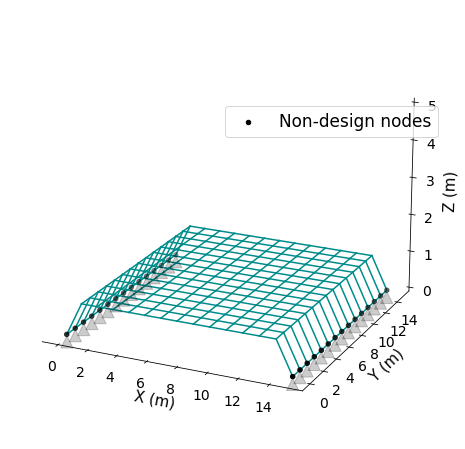

In [6]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,5)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -65)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

Define the objective function (with its gradient).

Create some lists/arrays to store the intermediate results.

In [7]:
params_store = [] #store parameters
f_store = [] #store the functional value 

In [8]:
def objective(x):
  params_store.append(x) #store params at each step
  z_nodes[design_nodes] = x #update the nodal coordiante

  ################
  #  SSO MODEL   #
  ################
  #Build the model
  sens_model = sso.Model_Sens.Model_Sens() #model for sensitivity analysis

  #Adding nodes and boundary conditions
  for i in range(n_node):
    
    sens_model.node(i,x_nodes[i],y_nodes[i],z_nodes[i])
    if i not in design_nodes:
      sens_model.add_support(i,[1,1,1,1,0,1]) #Pinned, only Ry allow

  #Adding elements
  for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) 
  
  #Adding load
  sens_model.add_nodal_load(f)

  #Conduct FEA
  sens_model.solve()
  u_disp = sens_model.u #global displacement
  C = 0.5*f@u_disp #compliance of the system
  f_store.append(C) #store the compliance 
 

  ##################
  #  Gradient  #
  ##################
  #Get the sensitivity using SSO
  sens = sens_model.Sens_C_Coord(u_disp)
  z_dof_index = design_nodes*3+2 #index indicating the z-dof
  sens_params = sens[z_dof_index] #storing the sensitivity of obj. wrt design parameters
  return C,sens_params

# Perform the optimization

In [9]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = z_nodes[design_nodes] #initial parameters 
optimizer = sso.Optimization.Optimization(n_x,method='GD')
optimizer.set_objective(objective) #objective function
optimizer.set_maxiter(500) #max iteration
optimizer.set_step_size(5e-2) #step size
optimizer.set_GD_normalized(True)
x_opt = optimizer.optimize(x_ini,log=True)

c:\ProgramData\Anaconda3\lib\site-packages\jax\_src\numpy\lax_numpy.py:2306: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  start = asarray(start, dtype=computation_dtype)
c:\ProgramData\Anaconda3\lib\site-packages\jax\_src\numpy\lax_numpy.py:2307: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  stop = asarray(stop, dtype=computation_dtype)
c:\ProgramData\Anaconda3\lib\site-packages\jax\_src\numpy\lax_numpy.py:2323: UserWarning: Explicitly requested dtype float64 requested in as

Step 0, objective = 206381.375
Step 1, objective = 181825.15625
Step 2, objective = 156282.09375
Step 3, objective = 131630.78125
Step 4, objective = 112558.546875
Step 5, objective = 95919.328125
Step 6, objective = 81737.1796875
Step 7, objective = 71123.4453125
Step 8, objective = 63126.5234375
Step 9, objective = 56920.22265625
Step 10, objective = 52491.6171875
Step 11, objective = 49299.43359375
Step 12, objective = 46111.5
Step 13, objective = 43240.484375
Step 14, objective = 40623.8515625
Step 15, objective = 38328.28125
Step 16, objective = 36189.265625
Step 17, objective = 34269.6640625
Step 18, objective = 32447.16015625
Step 19, objective = 30844.40625
Step 20, objective = 29331.052734375
Step 21, objective = 27966.55859375
Step 22, objective = 26693.634765625
Step 23, objective = 25516.171875
Step 24, objective = 24433.62890625
Step 25, objective = 23416.25
Step 26, objective = 22486.13671875
Step 27, objective = 21614.3046875
Step 28, objective = 20789.0859375
Step 29, o

# Visualization

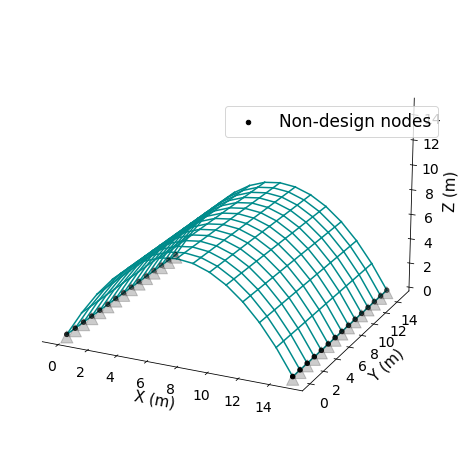

In [13]:
#Update the nodes
z_nodes[design_nodes] = x_opt
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,15)
ax.set_xlabel('X (m)',fontsize=15)
ax.set_ylabel('Y (m)',fontsize=15)
ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(x_nodes[non_design_nodes],y_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(20, -65)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()